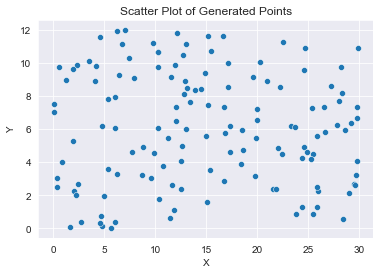

Generated Points: [(24.630013152109317, 4.8918972680839445), (25.508636347873722, 4.499768673859396), (0.38000347834355463, 2.503854128113374), (6.0090281979616, 6.03610221633242), (12.988730158672785, 6.008809877557286)]
Pairwise Distances: [[0.0, 0.9621556810328441, 24.367308411396067, 18.656105853746432, 11.69474084836749, 5.139433481758346, 19.72709245791903, 3.8174666974874425, 8.003901658203622, 2.517777190365476, 13.74493036096279, 12.017487509113923, 5.506565820314958, 5.759129985094207, 20.40924467431161, 19.11922526610409, 20.39670708165474, 24.39193307848658, 23.522377202747265, 11.254749670816974, 9.647576643035652, 19.864677720493564, 11.54936991059442, 5.227714239578433, 14.319454549256498, 5.393186316902135, 4.908100614416556, 21.092964719122367, 7.314142482158953, 5.32106601056438, 13.395911348905287, 2.198453463862013, 2.9359846809570103, 15.800700959636455, 9.838956992642025, 4.576553574649955, 14.745907210151554, 24.524695188976775, 19.49460337778435, 0.4008770352883

In [97]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import time
from typing import List

def generate_points(length, height, num_points):
    points = []
    for i in range(num_points):
        x = random.uniform(0, length)
        y = random.uniform(0, height)
        points.append((x, y))

    sns.set_style('darkgrid')
    plt.figure(figsize=(6, 4))
    ax = sns.scatterplot(x=[p[0] for p in points], y=[p[1] for p in points])
    plt.title('Scatter Plot of Generated Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

    #pairwise distances
    distances = []
    for i in range(num_points):
        row = []
        for j in range(num_points):
            dist = sqrt((points[i][0] - points[j][0]) ** 2 + (points[i][1] - points[j][1]) ** 2)
            row.append(dist)
        distances.append(row)

    return points, distances

length = 30.0
height = 12.0
num_points = 136
#num_points = 15

source_points, source_distances = generate_points(length, height, num_points)
print('Generated Points:', source_points[:5])
print('Pairwise Distances:', source_distances[:1])

In [98]:
def calculate_length(route: List[int], distances: List[List[float]]) -> float:
    if len(route) != len(distances):
        raise ValueError("Route and distances lists must have the same length")
    
    length = 0
    for i in range(len(route) - 1):
        if route[i] < 0 or route[i] >= len(distances) or route[i+1] < 0 or route[i+1] >= len(distances):
            raise ValueError("Invalid index in route list")
        length += distances[route[i]][route[i+1]]
    length += distances[route[-1]][route[0]]
    return length


In [99]:
import numpy as np
import itertools

def find_shortest_route(points):

    num_points = len(points)
    distances = [[0] * num_points for _ in range(num_points)]
    for i in range(num_points):
        for j in range(num_points):
            dist = sqrt((points[i][0] - points[j][0]) ** 2 + (points[i][1] - points[j][1]) ** 2)
            distances[i][j] = dist

    current_point = random.randint(0, num_points - 1)
    route = [current_point]

    while len(route) < num_points:
        nearest_neighbor = None
        nearest_distance = float('inf')
        for i in range(num_points):
            if i not in route and distances[current_point][i] < nearest_distance:
                nearest_neighbor = i
                nearest_distance = distances[current_point][i]
        
        route.append(nearest_neighbor)
        current_point = nearest_neighbor

    length = 0
    for i in range(num_points):
        length += distances[route[i]][route[(i + 1) % num_points]]

    return route, length

start_time = time.time()
shortest_route, shortest_length = find_shortest_route(source_points)
end_time = time.time()
bruteForceTime = end_time - start_time

In [100]:
from typing import List, Tuple
from math import sqrt
from random import randrange

def two_opt_algorithm(points: List[Tuple[float, float]], shortest_route: List[int], shortest_length: float, max_iterations: int=1000) -> Tuple[List[int], float]:

    point_dict = {point: i for i, point in enumerate(points)}
    indices = shortest_route.copy()

    def calculate_length(route: List[int]) -> float:
        length = 0
        for i in range(len(route) - 1):
            dist = sqrt((points[route[i]][0] - points[route[i+1]][0]) ** 2 + (points[route[i]][1] - points[route[i+1]][1]) ** 2)
            length += dist
        return length

    best_route = indices.copy()
    best_length = shortest_length
    for i in range(max_iterations):

        idx1, idx2 = sorted([randrange(len(points)) for _ in range(2)])
        new_route = indices[:idx1] + indices[idx1:idx2+1][::-1] + indices[idx2+1:]
        new_length = calculate_length(new_route)

        if new_length < best_length:
            best_route = new_route.copy()
            best_length = new_length

        indices = best_route.copy()

    optimized_route = [list(point_dict.keys())[list(point_dict.values()).index(idx)] for idx in best_route]
    optimized_route = [points.index(point) + 1 for point in optimized_route]

    return optimized_route, best_length

start_time = time.time()
twoopt_optimized_route, twoopt_optimized_length = two_opt_algorithm(source_points, shortest_route, shortest_length)
end_time = time.time()
twoOptTime = end_time - start_time


In [101]:

import numpy as np
import random

def aco(distances, num_ants, num_iterations, decay, alpha=1, beta=1):
    num_points = len(distances)
    pheromone = np.ones((num_points, num_points))
    best_path = None
    best_distance = float('inf')
    for it in range(num_iterations):
        paths = []
        distances_ = []
        for ant in range(num_ants):
            current = random.randint(0, num_points - 1)
            path = [current]
            distance_ = 0
            visited = set()
            visited.add(current)
            unvisited = set(range(num_points))
            unvisited.remove(current)
            while unvisited:
                weights = [((pheromone[current][j])**alpha)*((1/distances[current][j])**beta) for j in unvisited]
                selected = random.choices(list(unvisited), weights=weights, k=1)[0]
                path.append(selected)
                visited.add(selected)
                unvisited.remove(selected)
                distance_ += distances[current][selected]
                current = selected
            paths.append(path)
            distances_.append(distance_)
        pheromone *= (1 - decay)
        for i in range(num_ants):
            distance_ = distances_[i]
            path = paths[i]
            for j in range(num_points - 1):
                x = path[j]
                y = path[j+1]
                pheromone[x][y] += 1/distance_
        idx = np.argmin(distances_)
        if distances_[idx] < best_distance:
            best_path = paths[idx]
            best_distance = distances_[idx]
    return best_path, best_distance

# example usage
num_ants = 100
num_iterations = 1000
decay = 0.1
alpha = 1
beta = 1

start_time = time.time()
ac_shortest_path, ac_distance = aco(source_distances, num_ants, num_iterations, decay, alpha, beta)
end_time = time.time()
acTime = end_time-start_time
#print("Best path found:", best_path)
#print("Distance of best path:", best_distance)


In [102]:
import numpy as np

def nearest_neighbour_algorithm(dist_matrix):
    dist_matrix = np.array(dist_matrix)
    num_cities = dist_matrix.shape[0]
    visited_cities = np.zeros(num_cities, dtype=bool)    
    path = [0]
    visited_cities[0] = True
    total_distance = 0
    for i in range(num_cities-1):
        current_city = path[-1]
        nearest_neighbour_index = np.argmin(dist_matrix[current_city][visited_cities==False])
        nearest_neighbour = np.arange(num_cities)[visited_cities==False][nearest_neighbour_index]
        path.append(nearest_neighbour)
        visited_cities[nearest_neighbour] = True
        total_distance += dist_matrix[current_city][nearest_neighbour]
    # Add distance from last city to the starting city
    total_distance += dist_matrix[path[-1]][0]
    return path, total_distance

start_time = time.time()
nna_route, nna_length = nearest_neighbour_algorithm(source_distances)
end_time = time.time()
nnaTime = end_time-start_time


In [103]:
import numpy as np

def greedy_algorithm(dist_matrix):
    dist_matrix = np.array(dist_matrix)
    num_cities = dist_matrix.shape[0]
    visited_cities = np.zeros(num_cities, dtype=bool)
    path = [0]
    visited_cities[0] = True
    total_distance = 0
    for i in range(num_cities-1):
        current_city = path[-1]
        nearest_neighbour_index = np.argmin(dist_matrix[current_city][visited_cities==False])
        nearest_neighbour = np.arange(num_cities)[visited_cities==False][nearest_neighbour_index]
        path.append(nearest_neighbour)
        visited_cities[nearest_neighbour] = True
        total_distance += dist_matrix[current_city][nearest_neighbour]
    # Add distance from last city to the starting city
    total_distance += dist_matrix[path[-1]][0]
    return path, total_distance

start_time = time.time()
greedy_path, greedy_distance = greedy_algorithm(source_distances)
end_time = time.time()
greedyTime = end_time-start_time


In [104]:
import pandas as pd

'''
outputDataframe = {

    "Algorithm"         : ["Brute force", "Two Opt Algorithm", "Three Opt Algorithm", "Genetic Algorithm", "Ant Colony Optimization", "Particle Swarm Optimization", "Lin Kernighan", "Simulated Annealing"] ,
    "Distance"          : [shortest_length, twoopt_optimized_length, threeopt_optimized_length, ga_distance, ac_distance, pso_length, linKernighan_length, simAnnealing_length],
    "Calculation Time"  : [bruteForceTime, twoOptTime, threeOptTime, gaTime, acTime, psoTime, linKernighanTime, simAnnealingTime]

}
'''

outputDataframe = {

    "Algorithm"         : ["Greedy Algorithm", "Nearest Neighbour", "Two Opt Algorithm","Ant Colony Optimization"],
    "Distance"          : [greedy_distance, shortest_length, twoopt_optimized_length, ac_distance],
    "Calculation Time"  : [greedyTime, bruteForceTime, twoOptTime, acTime]

}

df = pd.DataFrame(outputDataframe)
print(df)

                 Algorithm    Distance  Calculation Time
0         Greedy Algorithm  237.217986          0.000000
1        Nearest Neighbour  214.259205          0.028008
2        Two Opt Algorithm  206.267372          0.132377
3  Ant Colony Optimization  183.787386        964.771647


In [105]:
sumTime = bruteForceTime + twoOptTime +  acTime + greedyTime
print(sumTime)

964.9320328235626
